In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Neural Network avec selection de features 

Ici on utilise keras pour faciliter les prototypes.

## Librairies 

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Données 

In [4]:
from transplant.data.learningset import Learningset

learningset = Learningset()

#X_train, X_test, y_train, y_test, X_col = learningset.get_data_merged_dynamic_flatten_full()
train, test = learningset.get_data_merged_dynamic_flatten_full(full_df=True)

In [5]:
## feature dans tous les RFE des 4 modèles d'ensemble  
choix_features_1=['PEEPtotal_std',
 'Temp_mean',
 'ETCO2_mean',
 'FiO2_std',
 'LAS',
 'Poids',
 'SpO2_mean',
 'BIS SR_std']

In [6]:
## choix 1 + SelectkBest chi2 modèle linéaire
choix_features_2=['PEEPtotal_std',
 'Temp_mean',
 'ETCO2_mean',
 'FiO2_std',
 'LAS',
 'Poids',
 'SpO2_mean',
 'Age_donor',
 'LAS',
 'PF_donor',
 'Poids',
 'Tabagisme_donor',
 'time_on_waiting_liste',
 'start_operation_day',
 'ends_operation_day',
 'B.I.S_mean',
 'VT_mean',
 'BIS SR_std',
 'SpO2_std',
 'B.I.S_max',
 'BIS SR_max',
 'VT_max',
 'FC_min',
 'FiO2_min',
 'PAPdia_min',
 'PASm_min',
 'SpO2_min']

In [7]:
## Significativité 10% modèles économétriques
choix_features_3=['start_operation_month',    
'ends_operation_month',     
'PAPsys_mean',              
'Temp_mean',                
'B.I.S_std',                  
'PAPdia_std',               
'PAPmoy_std',              
'PAPsys_std',               
'B.I.S_max',                  
'PAPmoy_max',               
'PAPsys_max',              
'SvO2 (m)_max',               
'PAPmoy_min',               
'PAPsys_min'] 

In [8]:
list(train.columns)

['Age_donor',
 'Aspirations_donor',
 'BMI_donor',
 'Donneur_CPT',
 'Insuffisance_renale',
 'LAS',
 'PAPS',
 'PFO',
 'PF_donor',
 'Poids',
 'Poids_donor',
 'RX_donor',
 'Sex_donor',
 'Tabagisme_donor',
 'Taille',
 'Taille_donor',
 'age',
 'body_mass_index',
 'diabetes',
 'id_patient',
 'other_organ_transplantation',
 'oto_score',
 'pathologie',
 'plasmapherese',
 'preoperative_ECMO',
 'preoperative_ICU',
 'preoperative_mechanical_ventilation',
 'preoperative_pulmonary_hypertension',
 'preoperative_vasopressor',
 'retransplant',
 'sexe',
 'super_urgence',
 'thoracic_surgery_history',
 'time_on_waiting_liste',
 'transplanted_twice_during_study_period',
 'target',
 'start_operation_year',
 'start_operation_month',
 'start_operation_day',
 'ends_operation_year',
 'ends_operation_month',
 'ends_operation_day',
 'B.I.S_mean',
 'BIS SR_mean',
 'DC_mean',
 'ETCO2_mean',
 'FC_mean',
 'FR_mean',
 'FiO2_mean',
 'PAPdia_mean',
 'PAPmoy_mean',
 'PAPsys_mean',
 'PASd_mean',
 'PASm_mean',
 'PASs_mean'

In [9]:
##Choix Antoine mis en perspective RFE
choix_features_4=['FiO2_std','FiO2_mean',
                  'SpO2_mean','SpO2_std',
                  'PEEPtotal_mean',
                  'BIS SR_std',
                  'PAPsys_max','PAPsys_std',
                  'PASs_mean','PASm_max',
                  'LAS',
                  'FC_std'#,
                  #'super_urgence' ->> bizarre réduit beaucoup l'acc
                 ]

In [10]:
choix_features_5=set(choix_features_4 + choix_features_1) ## Le meilleur for now

In [11]:
## Choix Antoine avec mean et std
## En fait est inutile 
choix_features_6=['FiO2_std','FiO2_mean',
                  'SpO2_mean','SpO2_std',
                  'PEEPtotal_mean','PEEPtotal_std',
                  'BIS SR_std','BIS SR_mean',
                  'PAPsys_max','PAPsys_std','PAPsys_mean',
                  'PASs_mean','PASm_max','PASm_std',
                  'LAS',
                  'FC_std','FC_mean'
                  #'super_urgence' ->> bizarre réduit beaucoup l'acc
                 ]

In [12]:
choix_features_7=set(choix_features_6 + choix_features_1)

In [13]:
choix_features_8=['FiO2_std','FiO2_mean','FiO2_max','FiO2_min',
                  'SpO2_mean','SpO2_std','SpO2_max','SpO2_min',
                  'PEEPtotal_mean','PEEPtotal_std','PEEPtotal_max','PEEPtotal_min',
                  'BIS SR_std','BIS SR_mean','BIS SR_max','BIS SR_min',
                  'PAPsys_max','PAPsys_std','PAPsys_mean','PAPsys_min',
                  'PASs_mean','PASm_max','PASm_std','PASm_min',
                  'LAS',
                  'FC_std','FC_mean','FC_min','FC_max'
                  #'super_urgence' ->> bizarre réduit beaucoup l'acc
                 ]

In [14]:
choix_features_9=set(choix_features_8 + choix_features_1) ##Pas bon

##### On choisit les features ici :

In [15]:
Choix_Features=choix_features_5

### Ici on peut regarder les corrélations des features qu'on a choisit 

#### Attention : 

Ce n'est pas parce que vos features sont corrélées qu'il faille forcement les enlever. 

Parfois il semble que cela réduise la qualité de nos résultats.

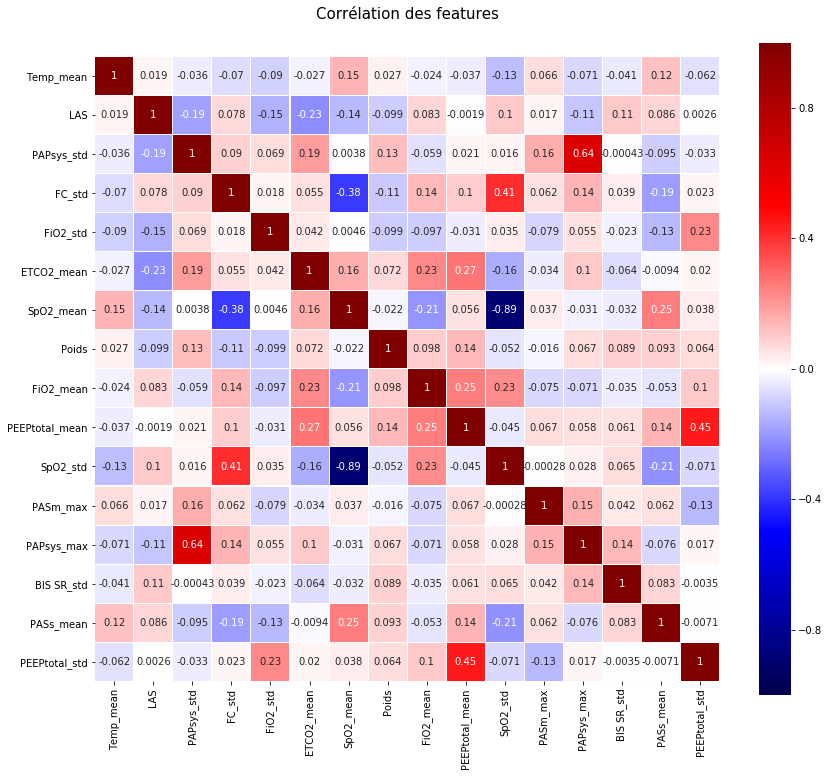

In [16]:
matrice_corr=train[Choix_Features].corr()#'spearman') #Corrélations linéaires et non linéaires

colormap = plt.cm.seismic
plt.figure(figsize=(14,12))
plt.title('Corrélation des features', y=1.05, size=15)
sns.heatmap(matrice_corr,linewidths=0.1,vmin=-1.0,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

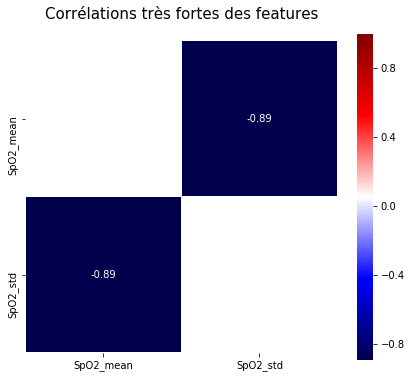

In [17]:
matrice_corr_forte=matrice_corr[(matrice_corr<-0.70) | ((matrice_corr>=0.70) & (matrice_corr<1))].dropna(how='all').dropna(axis=1,how='all')

if not(matrice_corr_forte.empty) :
    colormap = plt.cm.seismic
    plt.figure(figsize=(7,6))
    plt.title('Corrélations très fortes des features', y=1.05, size=15)
    sns.heatmap(matrice_corr_forte,linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)
else :
    print("Il n'y a aucune corrélation très forte ;) Let's go learn !")

In [18]:
num_feat=len(Choix_Features)

In [19]:
X_train=train[Choix_Features].values 
X_test=test[Choix_Features].values
y_train=train['target'].values
y_test=test['target'].values

In [20]:
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((241, 16), (101, 16), (241, 1), (101, 1))

In [22]:
# On utilise plus ça mais au cas où
#y_train = keras.utils.to_categorical(y_train, num_classes=2)
#y_test = keras.utils.to_categorical(y_test, num_classes=2)

##### Ici si on veut centrer réduire nos données ( pas de leakage car on utilise la réduction du train set sur le test set

In [23]:
from sklearn.preprocessing import StandardScaler

reduire_centrer=True


if reduire_centrer :
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train=scaler.transform(X_train)
    X_test=scaler.transform(X_test)
    
##On check avec X_train.mean(axis=0)

## Création du modèle

In [24]:
seed = 150

In [25]:
model = Sequential()
model.add(Dense(num_feat//2, input_dim=num_feat, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5)) #Très efficacee contre overfitting 
model.add(Dense(num_feat//8,  kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [26]:
np.random.seed(seed)

model.fit(X_train, y_train,
          epochs=100,
          batch_size=5)

Epoch 1/100
241/241 [==============================] - 1s 3ms/step - loss: 0.6927 - acc: 0.5685
Epoch 2/100
241/241 [==============================] - 0s 618us/step - loss: 0.6915 - acc: 0.5685
Epoch 3/100
241/241 [==============================] - 0s 664us/step - loss: 0.6900 - acc: 0.5685
Epoch 4/100
241/241 [==============================] - 0s 630us/step - loss: 0.6881 - acc: 0.5685
Epoch 5/100
241/241 [==============================] - 0s 630us/step - loss: 0.6859 - acc: 0.5685
Epoch 6/100
241/241 [==============================] - 0s 610us/step - loss: 0.6778 - acc: 0.5685
Epoch 7/100
241/241 [==============================] - 0s 601us/step - loss: 0.6757 - acc: 0.5685
Epoch 8/100
241/241 [==============================] - 0s 643us/step - loss: 0.6663 - acc: 0.5685 0s - loss: 0.6624 - acc: 0.584
Epoch 9/100
241/241 [==============================] - 0s 564us/step - loss: 0.6640 - acc: 0.5685
Epoch 10/100
241/241 [==============================] - 0s 593us/step - loss: 0.6532 - ac

241/241 [==============================] - 0s 514us/step - loss: 0.6023 - acc: 0.6680
Epoch 83/100
241/241 [==============================] - 0s 539us/step - loss: 0.6349 - acc: 0.6390
Epoch 84/100
241/241 [==============================] - 0s 742us/step - loss: 0.5975 - acc: 0.6929
Epoch 85/100
241/241 [==============================] - 0s 796us/step - loss: 0.5867 - acc: 0.6888
Epoch 86/100
241/241 [==============================] - 0s 705us/step - loss: 0.5921 - acc: 0.6349
Epoch 87/100
241/241 [==============================] - 0s 568us/step - loss: 0.6072 - acc: 0.6349
Epoch 88/100
241/241 [==============================] - 0s 543us/step - loss: 0.5979 - acc: 0.6722
Epoch 89/100
241/241 [==============================] - 0s 643us/step - loss: 0.6166 - acc: 0.6432
Epoch 90/100
241/241 [==============================] - 0s 560us/step - loss: 0.6233 - acc: 0.6556
Epoch 91/100
241/241 [==============================] - 0s 639us/step - loss: 0.6295 - acc: 0.6141
Epoch 92/100
241/241 [=

In [27]:
np.random.seed(seed)
score = model.evaluate(X_test, y_test, batch_size=50)

101/101 [==============================] - 0s 1ms/step


In [28]:
score 

[0.6163895991769167, 0.6336633521731537]

## Résultats 

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [30]:
y_test_pred_cls=(model.predict(X_test)>0.5)*1

In [31]:
conf_matrix=confusion_matrix(y_test,y_test_pred_cls)

In [32]:
conf_matrix/(len(y_test))

array([[0.37623762, 0.20792079],
       [0.15841584, 0.25742574]])

In [33]:
conf_matrix_proba=conf_matrix/(len(y_test))

In [34]:
print(metrics.classification_report(y_test,y_test_pred_cls))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        59
           1       0.55      0.62      0.58        42

   micro avg       0.63      0.63      0.63       101
   macro avg       0.63      0.63      0.63       101
weighted avg       0.64      0.63      0.64       101



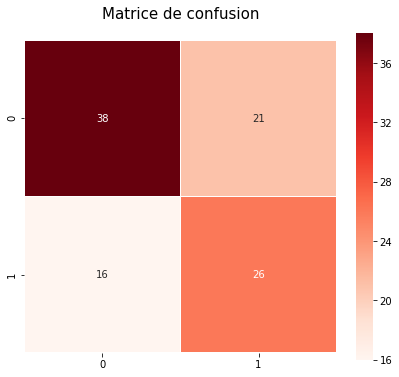

In [35]:
colormap = plt.cm.Reds
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion', y=1.05, size=15)
sns.heatmap(conf_matrix,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True)

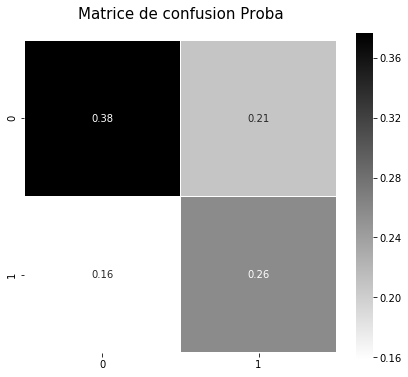

In [36]:
colormap = plt.cm.binary
plt.figure(figsize=(7,6))
plt.title('Matrice de confusion Proba', y=1.05, size=15)
sns.heatmap(conf_matrix_proba,linewidths=0.1, 
            square=True, cmap=colormap, linecolor='white', annot=True)